# Total Load Forecast in Switzerland

This projects takes data from the European Network of Transmission System [for electricity], where you can request an API Key from.

This project tries to forecast the total load of Switzerland on a weekahead basis.

## Data Collection

This project makes use of [entsoe-py](https://github.com/EnergieID/entsoe-py) to load the data directly into pandas frame.

In [1]:
import os
from entsoe import EntsoePandasClient
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.environ.get('API_KEY')

client = EntsoePandasClient(api_key=API_KEY)

start = pd.Timestamp('20191101', tz='Europe/Zurich')
end = pd.Timestamp('20211107', tz='Europe/Zurich')
country_code = 'CH'

df = client.query_load_and_forecast(country_code, start=start, end=end)

changing the dataframe so there is an index column and the timestamp becomes column with name time.

In [2]:
df = df.rename_axis('time')
df = df.tz_localize(None)
df.reset_index(inplace=True)

In [3]:
df

,time,Forecasted Load,Actual Load
0,2019-11-01 00:00:00,6711.0,6194.0
1,2019-11-01 01:00:00,6313.0,6272.0
2,2019-11-01 02:00:00,6312.0,6384.0
3,2019-11-01 03:00:00,6312.0,6563.0
4,2019-11-01 04:00:00,6309.0,6657.0
...,...,...,...
17678,2021-11-06 19:00:00,7657.0,7878.0
17679,2021-11-06 20:00:00,7584.0,7610.0
17680,2021-11-06 21:00:00,7528.0,7195.0
17681,2021-11-06 22:00:00,7332.0,7305.0


## Data Cleaning

Since there are missing values in the data set, namely missing timestamps which most likely were not recorded we are filling them up with the ffill method same values as previous once.

In [4]:
start_timestamp = pd.Timestamp('20191101')
end_timestamp = pd.Timestamp('20211107')

df_ts = pd.DataFrame(pd.date_range(start=start_timestamp, end=end_timestamp, freq='1H')[:-1], columns=['time'])
df_cleaned = pd.merge(df_ts, df.drop_duplicates(subset='time'), on='time', how='left').fillna(method='ffill')

## Data Processing

Looking at the actual total load from 01.11.19 until 07.11.21.

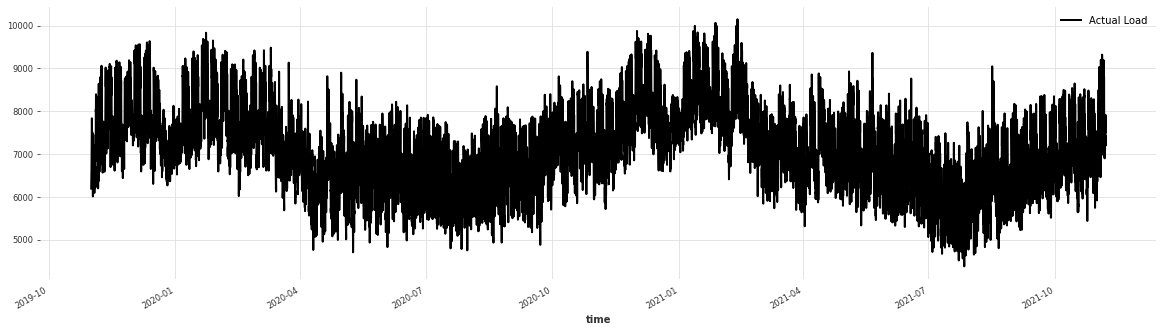

In [5]:
from darts import TimeSeries
import matplotlib.pyplot as plt

series = TimeSeries.from_dataframe(df_cleaned, 'time', 'Actual Load')
plt.figure(figsize=(20,5))
series.plot()

Splitting up the data into 2 years of training data and 7 day [weekahead forecast]

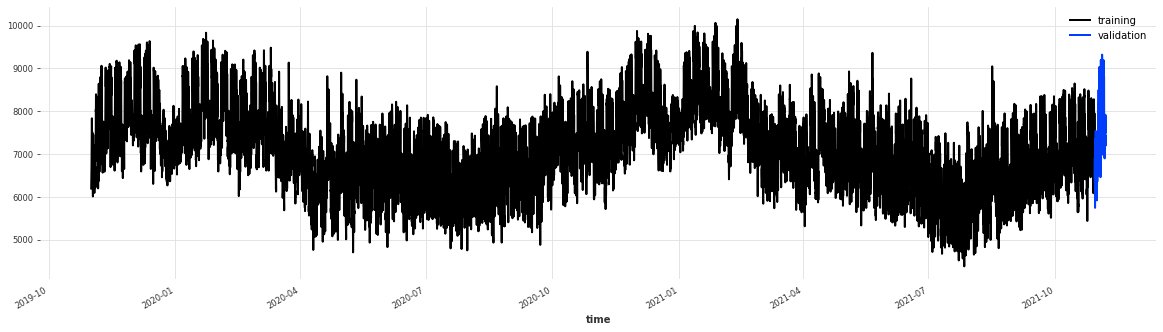

In [6]:
training, validation = series.split_before(pd.Timestamp('20211030'))
plt.figure(figsize=(20,5))
training.plot(label='training')
validation.plot(label='validation')

## Classical models

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


Currently calculating Linear Regression Model
Currently calculating Random Forest Model
Currently calculating Exponential Smoothing


/Users/Jorit/Projects/energy-systems-iot/.venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Currently calculating ARIMA


/Users/Jorit/Projects/energy-systems-iot/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Currently calculating AutoARIMA
Currently calculating Prophet


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


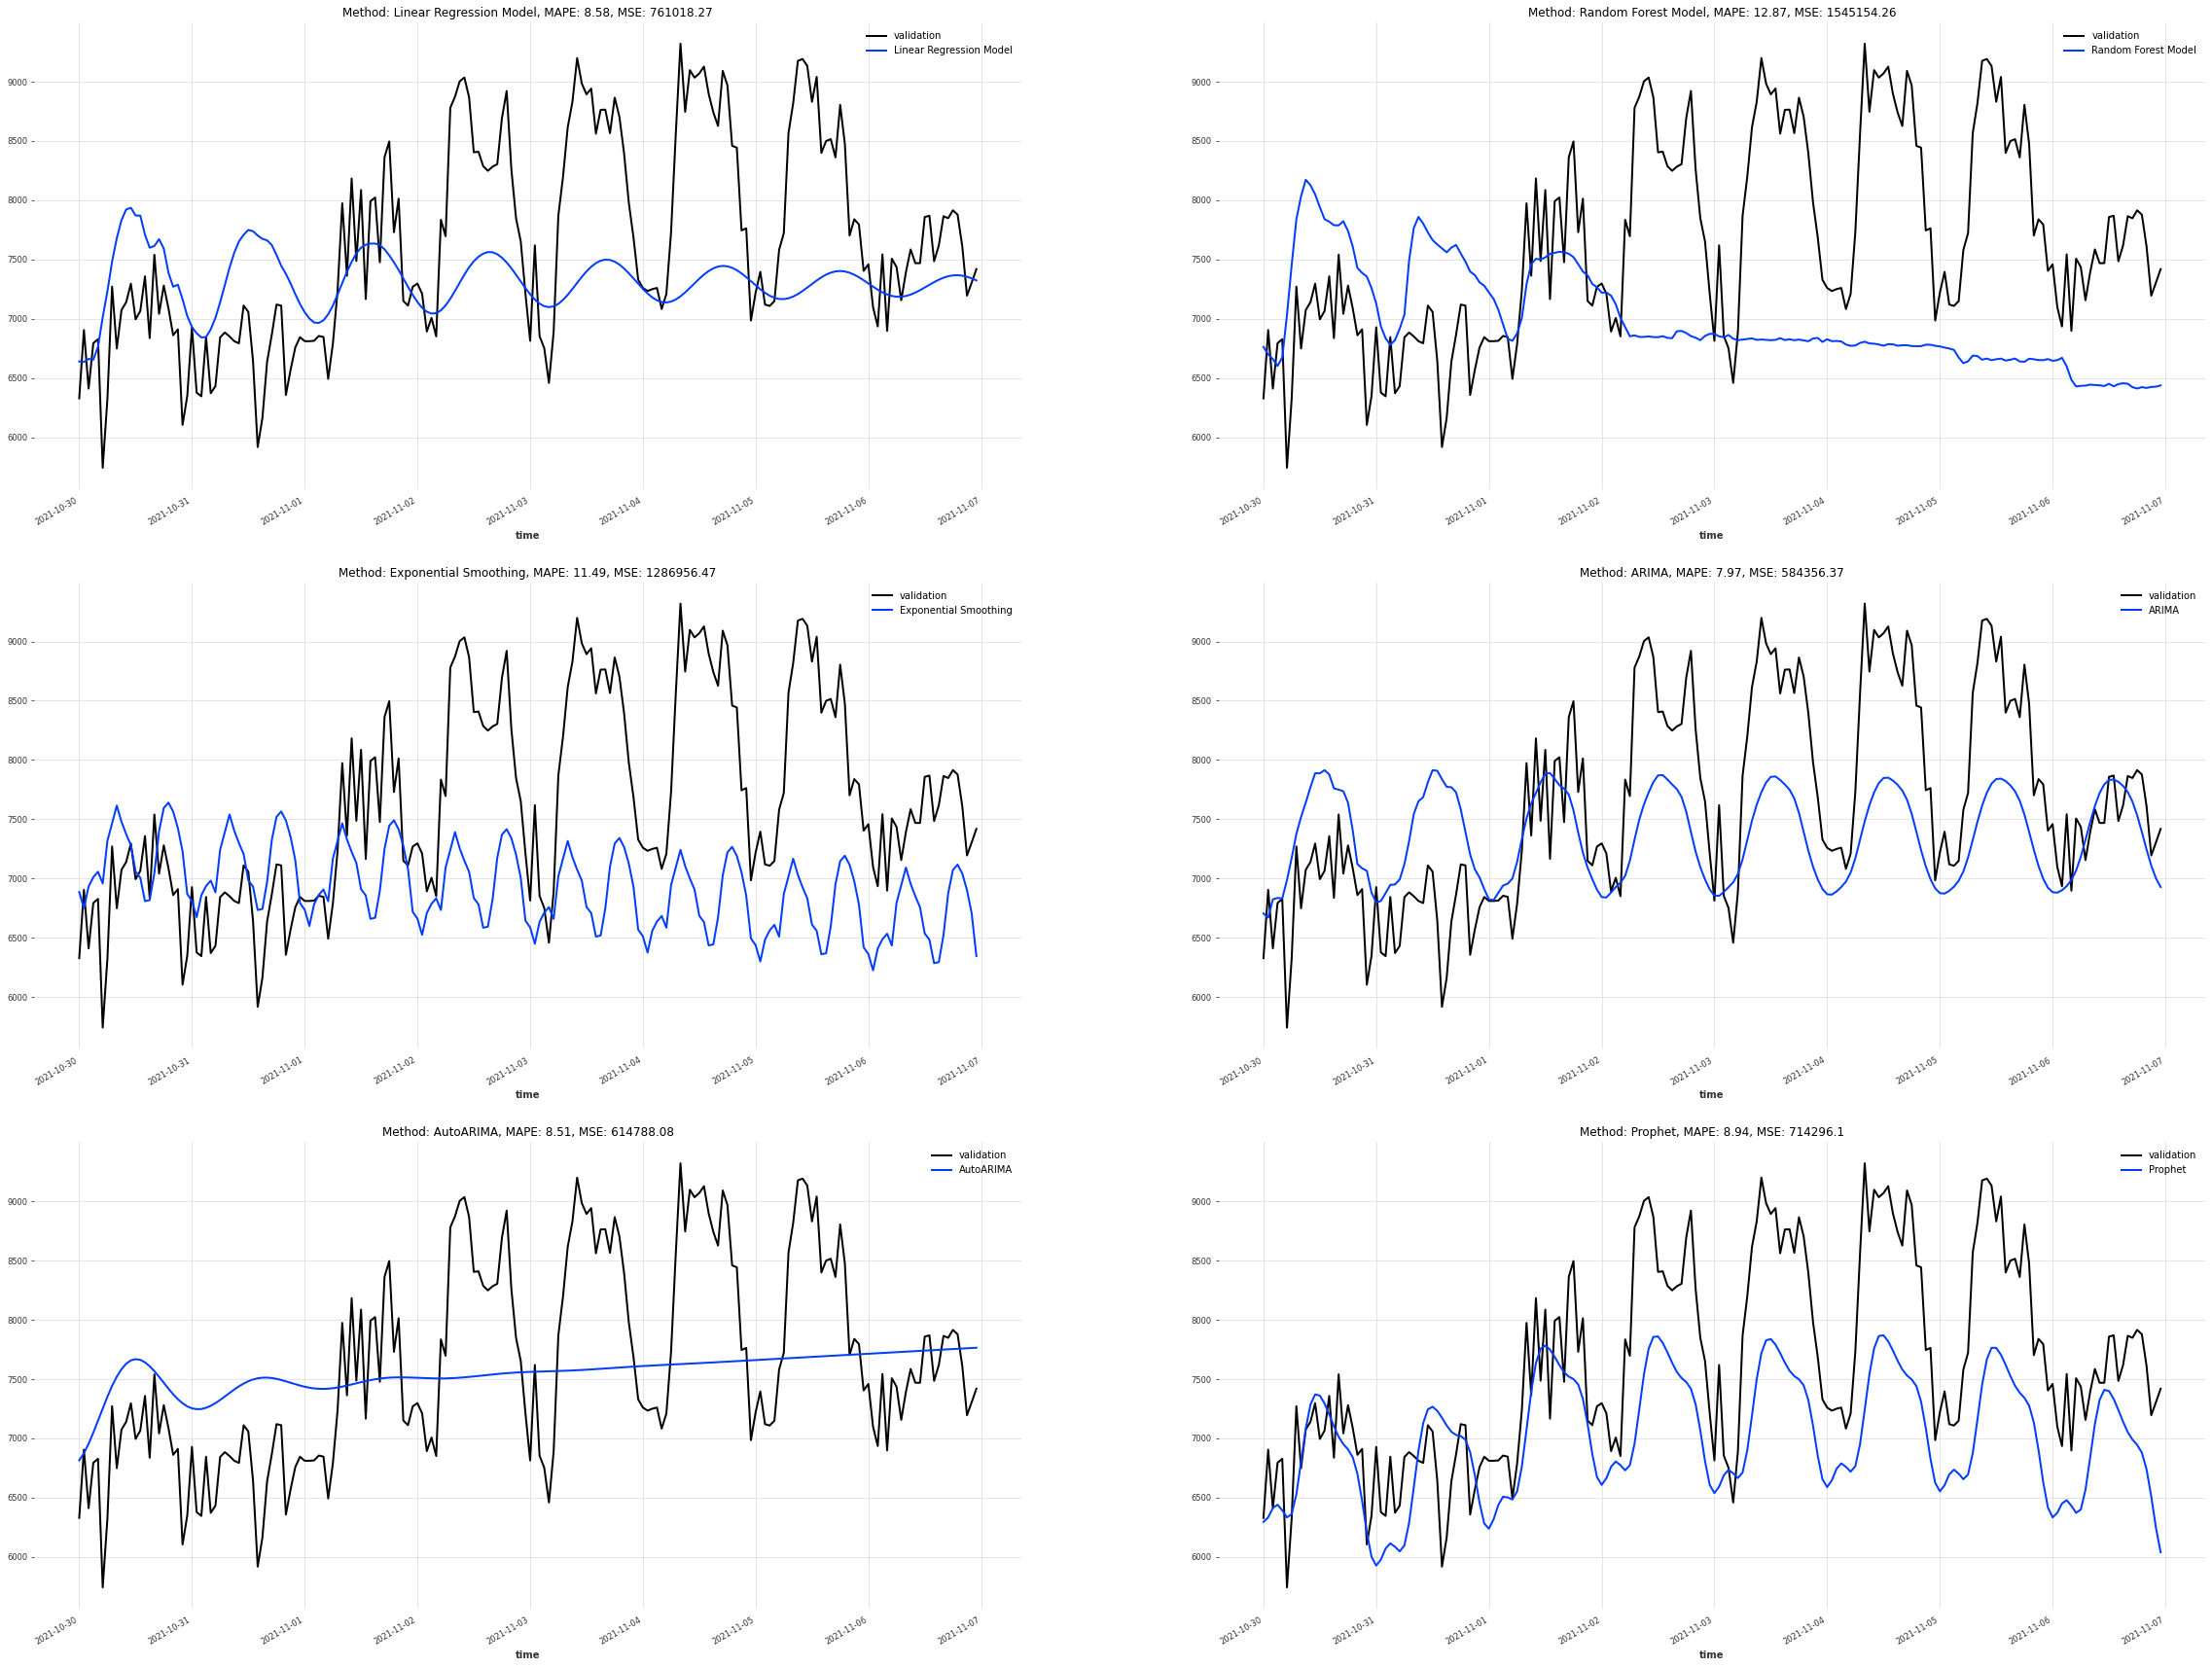

In [7]:
from darts.models import LinearRegressionModel, RandomForest, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet
from darts.metrics import mape, mse

# since we are using hourly data it makes sense to use the last 24 hours [lags] to predict the next value
model0 = LinearRegressionModel(lags=24)
model1 = RandomForest(lags=24, n_estimators=300) # don't really know what's a sensible number for amount of trees here, just chose 300
model2 = ExponentialSmoothing(seasonal_periods=24)
model3 = ARIMA(p=12, d=1, q=24)
model4 = AutoARIMA()
model5 = Prophet()

models = {
    "Linear Regression Model" : model0,
    "Random Forest Model" : model1,
    "Exponential Smoothing" : model2,
    "ARIMA" : model3,
    "AutoARIMA" : model4,
    "Prophet" : model5
}

fig = plt.figure(figsize=(40, 30))
for i, (name, model) in enumerate(models.items()):
    print(f"Currently calculating {name}")
    model.fit(series=training)
    predictions = model.predict(n=len(validation))
    mape_score = round(mape(validation, predictions), 2)
    mse_score = round(mse(validation, predictions), 2)

    # plotting figure
    fig.add_subplot(3, 2, i+1)
    #training.plot(label="training")
    validation.plot(label="validation")
    predictions.plot(label=name)
    plt.title(f"Method: {name}, MAPE: {mape_score}, MSE: {mse_score}")
    plt.legend()
# fig.tight_layout()
plt.show()

## Temperature as an additional covariate

We are selecting the timeframe chosen above and setting the time to type datetime...

In [8]:
temperature = pd.read_csv('temperature_cleaned.csv', sep=';')
temperature = temperature.drop('Unnamed: 0', 1)
temperature.rename(columns={'Datum': 'time'}, inplace=True)
mask = (temperature['time'] >= '2019-11-01 00:00:00') & (temperature['time'] <= '2021-11-06 23:00:00')
needed_temp = temperature.loc[mask]
needed_temp['time'] =  pd.to_datetime(needed_temp['time'])

/var/folders/3f/2n320c6d61n9ypp1nrkct_5h0000gn/T/ipykernel_80389/3426242240.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  temperature = temperature.drop('Unnamed: 0', 1)
/var/folders/3f/2n320c6d61n9ypp1nrkct_5h0000gn/T/ipykernel_80389/3426242240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needed_temp['time'] =  pd.to_datetime(needed_temp['time'])


replacing all missing values in the temperature dataset again using the ffill method...

In [9]:
print(f"There are {len(needed_temp[pd.to_datetime(needed_temp['time']).diff() > '01:00:00'].index.values)} missing rows")

start_timestamp = pd.Timestamp('20191101')
end_timestamp = pd.Timestamp('20211107')

df_ts = pd.DataFrame(pd.date_range(start=start_timestamp, end=end_timestamp, freq='1H')[:-1], columns=['time'])
temperature_cleaned = pd.merge(df_ts, needed_temp.drop_duplicates(subset='time'), on='time', how='left').fillna(method='ffill')

print(f"There are {len(temperature_cleaned[pd.to_datetime(temperature_cleaned['time']).diff() > '01:00:00'].index.values)} missing rows after cleaning")


There are 251 missing rows
There are 0 missing rows after cleaning


We are merging the total load data with the temperature data...

In [10]:
final_df = pd.merge(df_cleaned, temperature_cleaned, on='time')
final_df.rename(columns={'OBFELDEN': 'Temperature in Obfelden'}, inplace=True)

final_df.head(10)

,time,Forecasted Load,Actual Load,Temperature in Obfelden
0,2019-11-01 00:00:00,6711.0,6194.0,-2.0
1,2019-11-01 01:00:00,6313.0,6272.0,-2.0
2,2019-11-01 02:00:00,6312.0,6384.0,-2.4
3,2019-11-01 03:00:00,6312.0,6563.0,-4.6
4,2019-11-01 04:00:00,6309.0,6657.0,-6.0
5,2019-11-01 05:00:00,6317.0,6521.0,-4.5
6,2019-11-01 06:00:00,6462.0,6733.0,-4.3
7,2019-11-01 07:00:00,6863.0,7107.0,-4.4
8,2019-11-01 08:00:00,7286.0,7129.0,-5.1
9,2019-11-01 09:00:00,7206.0,7455.0,-1.9


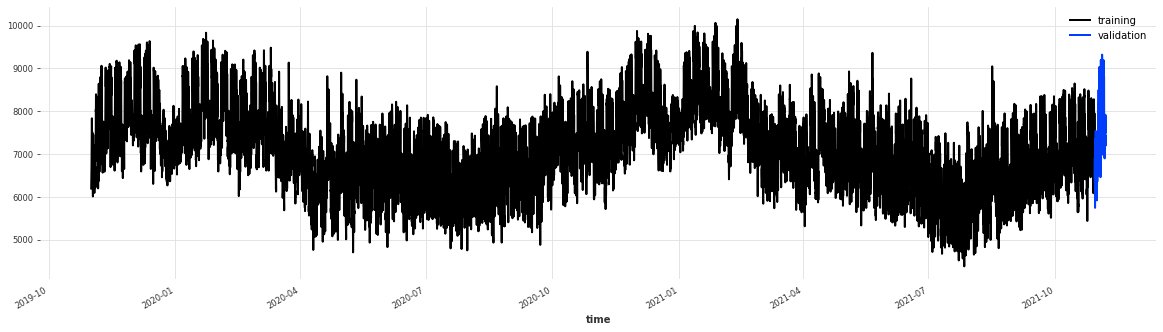

In [11]:
from darts import TimeSeries
import matplotlib.pyplot as plt

series = TimeSeries.from_dataframe(final_df, 'time', 'Actual Load', 'Temperature in Obfelden')

training, validation = series.split_before(pd.Timestamp('20211030'))
plt.figure(figsize=(20,5))
training.plot(label='training')
validation.plot(label='validation')

Currently calculating ARIMA


/Users/Jorit/Projects/energy-systems-iot/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Currently calculating Prophet


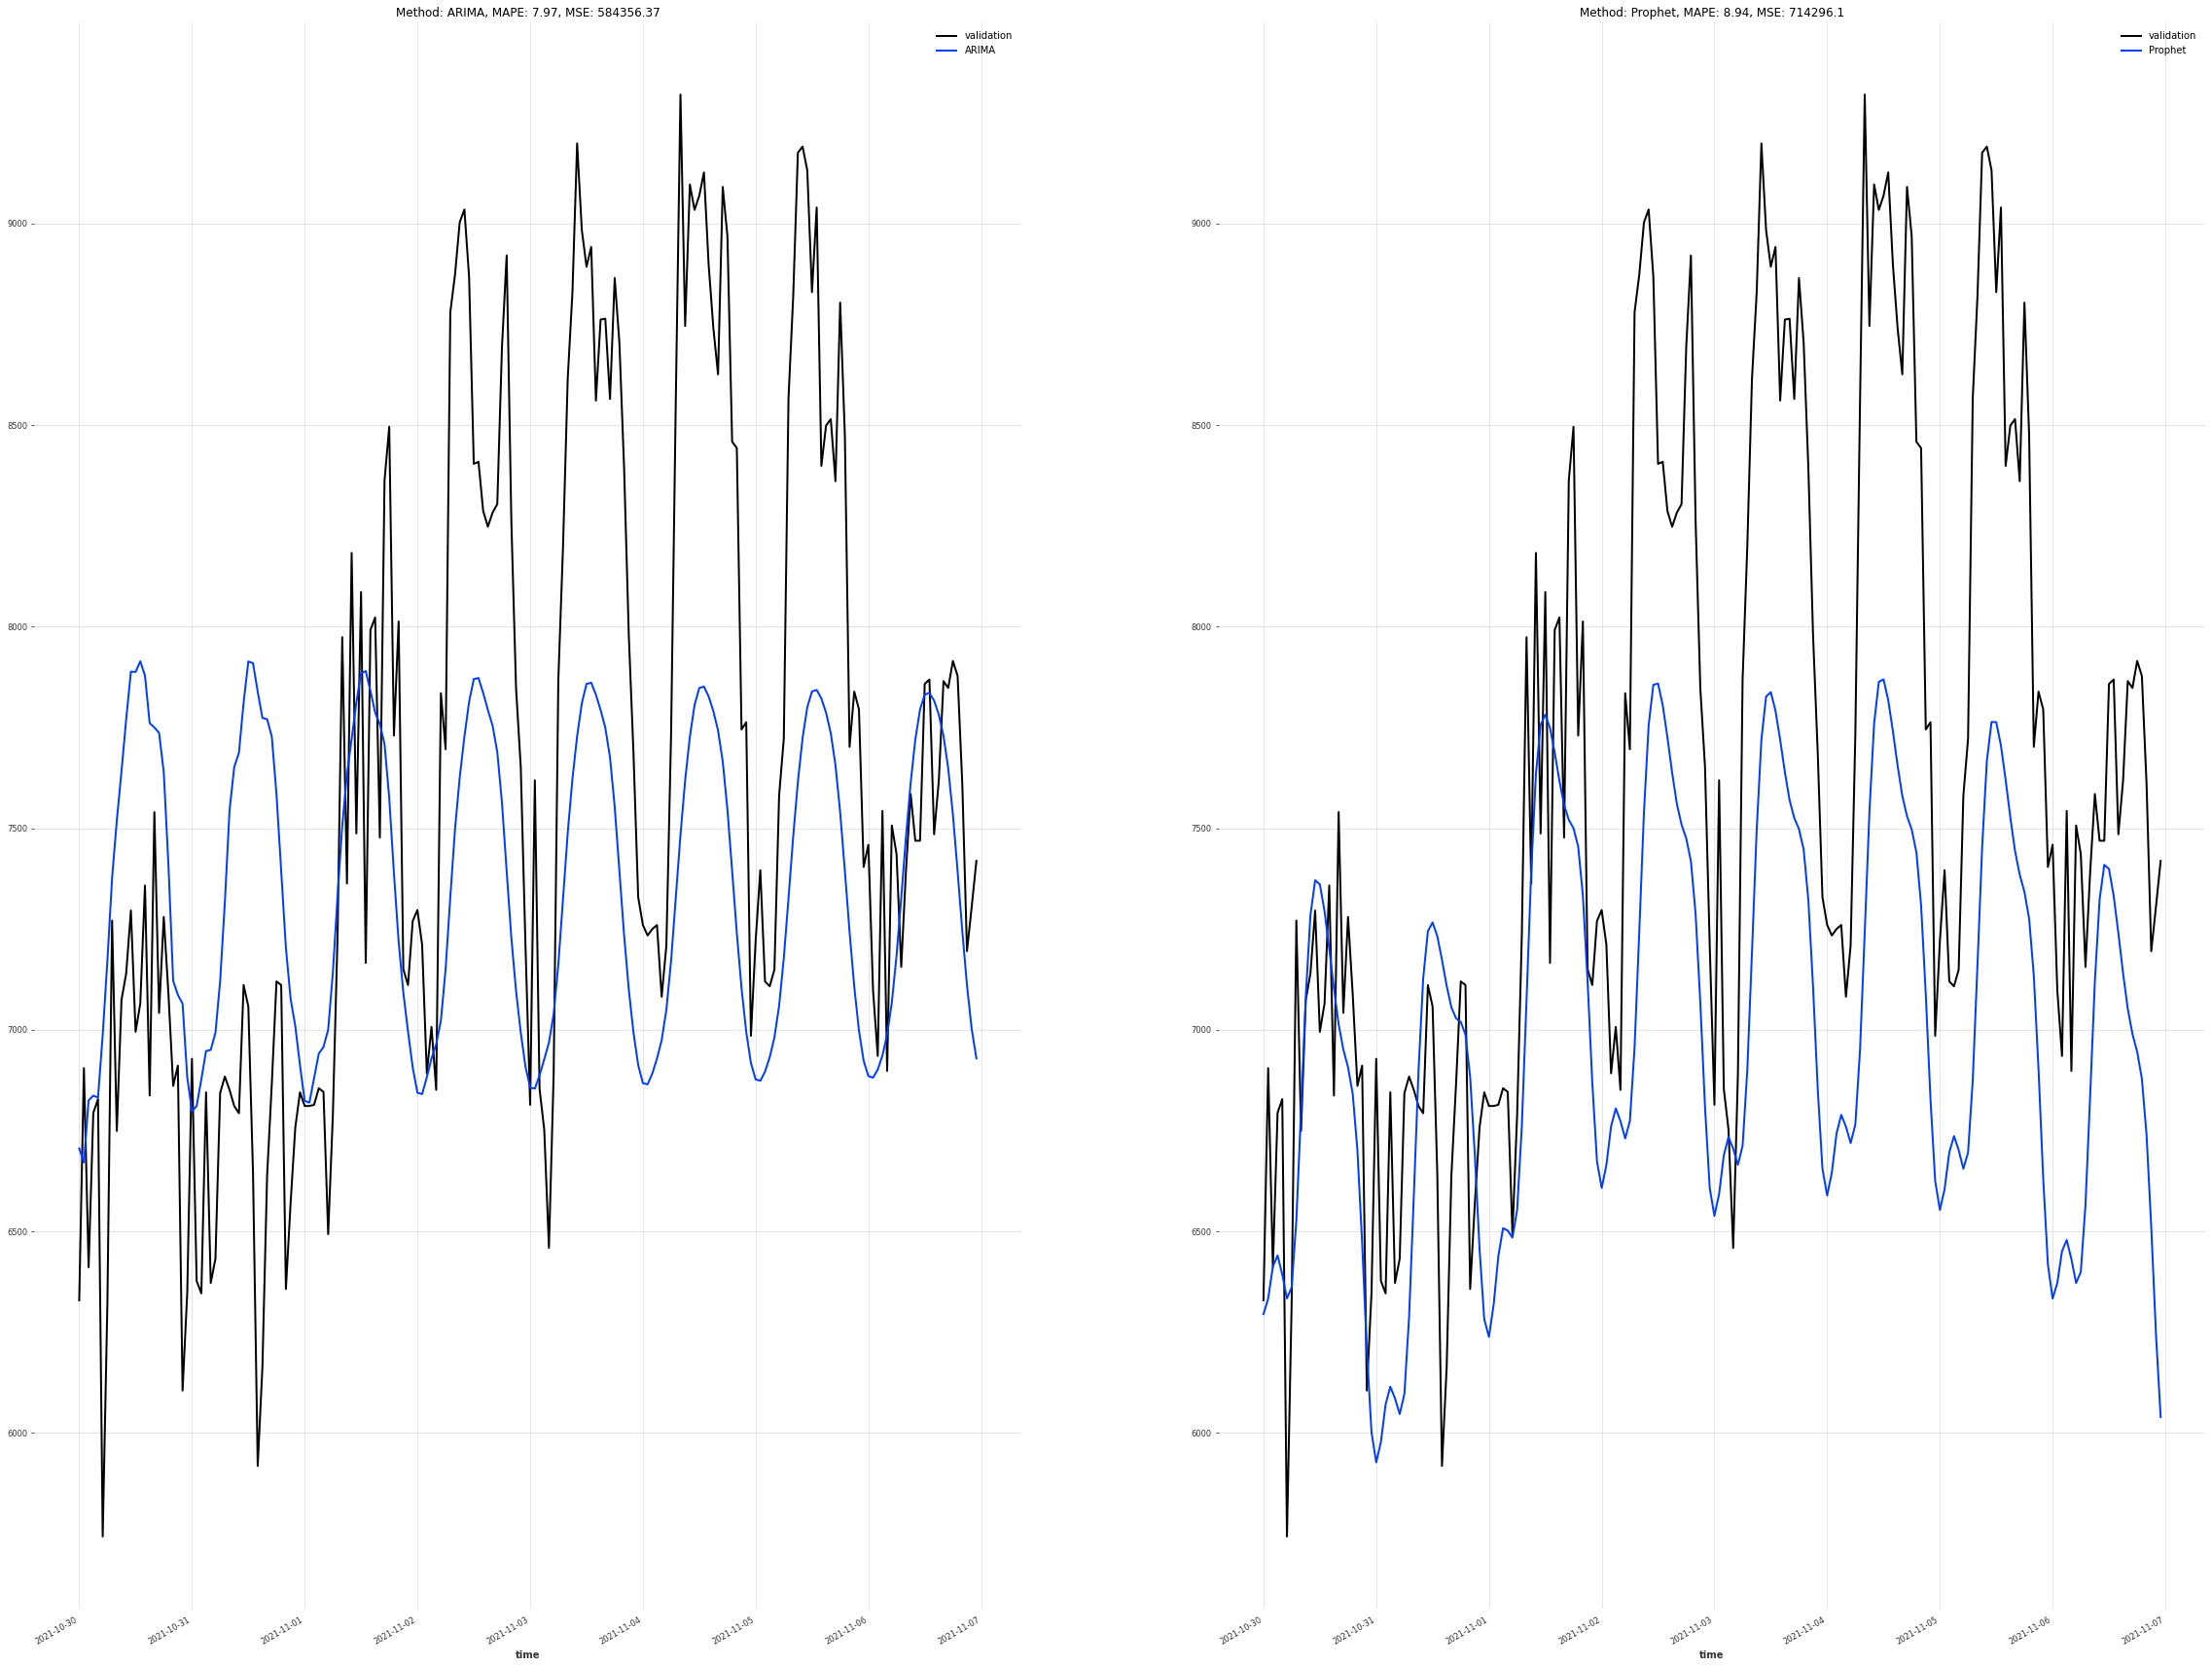

In [12]:
from darts.models import ARIMA, Prophet
from darts.metrics import mape, mse

final_model_0 = ARIMA(p=12, d=1, q=24)
final_model_1 = Prophet()

models = {
    "ARIMA" : final_model_0,
    "Prophet" : final_model_1
}

fig = plt.figure(figsize=(40, 30))
for i, (name, model) in enumerate(models.items()):
    print(f"Currently calculating {name}")
    model.fit(series=training)
    predictions = model.predict(n=len(validation))
    mape_score = round(mape(validation, predictions), 2)
    mse_score = round(mse(validation, predictions), 2)

    # plotting figure
    fig.add_subplot(1, 2, i+1)
    #training.plot(label="training")
    validation.plot(label="validation")
    predictions.plot(label=name)
    plt.title(f"Method: {name}, MAPE: {mape_score}, MSE: {mse_score}")
    plt.legend()
# fig.tight_layout()
plt.show()

## Temporal Features

In [13]:
import numpy as np
import holidays

def get_temporal_features_(index, features, n_cos_sin_hour=6, n_cos_sin_weekday=42, n_cos_sin_year=2):
    """
    get a df of temporal features specified for an index and the specified features
    """
    temporal_features = pd.DataFrame(index=index)
    if 'hour' in features:
        hour = index.hour
        for i in range(1, int(n_cos_sin_hour) + 1):
            hour_sin = np.sin(i * (2 / 24) * np.pi * hour).astype(float)
            hour_cos = np.cos(i * (2 / 24) * np.pi * hour).astype(float)
            temporal_features['hour_sin_{}'.format(i)] = hour_sin
            temporal_features['hour_cos_{}'.format(i)] = hour_cos

    if 'weekhour' in features:
        hour = index.hour + index.weekday * 24
        for i in range(1, int(n_cos_sin_weekday) + 1):
            hour_sin = np.sin(i * (2 / 24) * np.pi * hour).astype(float)
            hour_cos = np.cos(i * (2 / 24) * np.pi * hour).astype(float)
            temporal_features['weekhour_sin_{}'.format(i)] = hour_sin
            temporal_features['weekhour_cos_{}'.format(i)] = hour_cos

    if 'weekday' in features:
        weekday = index.weekday
        weekdays = pd.get_dummies(weekday, prefix='weekday').astype(float)
        weekdays.index = temporal_features.index
        temporal_features = pd.concat([temporal_features, weekdays], axis=1)

    if 'month' in features:
        month = index.month
        months = pd.get_dummies(month, prefix='month').astype(float)
        months.index = temporal_features.index
        temporal_features = pd.concat([temporal_features, months], axis=1)

    if 'dayofyear' in features:
        dayofyear = index.dayofyear
        for i in range(1, int(n_cos_sin_year) + 1):
            dayofyear_sin = np.sin(i * (2 / 365) * np.pi * dayofyear).astype(float)
            dayofyear_cos = np.cos(i * (2 / 365) * np.pi * dayofyear).astype(float)
            temporal_features['dayofyear_sin_{}'.format(i)] = dayofyear_sin
            temporal_features['dayofyear_cos_{}'.format(i)] = dayofyear_cos

    if 'holiday' in features:
        ch_holidays = holidays.CountryHoliday("CH")
        # ch_holidays = CountryHoliday('CH')
        # holiday = pd.Series(index.date).apply(lambda x: x in ch_holidays)
        # temporal_features['holiday'] = holiday.astype(int)
        temporal_features['holiday'] = pd.Series(index, index=index, name='holiday').apply(
            lambda x: x in ch_holidays).astype(int)
    if 'tz_shift' in features:
        """
        if there is a time shift (CET <-> CEST) then all the timestamp at this day = 1, no shift at this day = 0 
        """
        df_tz_info = pd.DataFrame()
        df_iteration = pd.DataFrame(data=[np.nan] * len(index), index=index).groupby(pd.Grouper(freq='D'))
        for key, daily_values in df_iteration:
            lst_tzinfo = [timestamp.tzinfo for timestamp in daily_values.index]
            if (all(tz_info == lst_tzinfo[0] for tz_info in lst_tzinfo)):
                df_tz_append = pd.DataFrame(data=[0] * len(daily_values), index=daily_values.index)
            else:
                df_tz_append = pd.DataFrame(data=[1] * len(daily_values), index=daily_values.index)
            df_tz_info = pd.concat([df_tz_info, df_tz_append], axis=0)
        df_tz_info.rename(columns={0: 'tz_shift'}, inplace=True)
        temporal_features['tz_shift'] = df_tz_info
    return temporal_features

In [14]:
final_df['time'] = pd.to_datetime(final_df['time'], utc=True)
final_df.index=pd.DatetimeIndex(final_df.time).tz_convert("CET")

cov = get_temporal_features_(final_df.index, ["weekhour", "dayofyear","weekday", "hour", "holiday"], n_cos_sin_hour = 6, n_cos_sin_weekday = 42, n_cos_sin_year = 2)

/var/folders/3f/2n320c6d61n9ypp1nrkct_5h0000gn/T/ipykernel_80389/2205406718.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  temporal_features['dayofyear_cos_{}'.format(i)] = dayofyear_cos
/var/folders/3f/2n320c6d61n9ypp1nrkct_5h0000gn/T/ipykernel_80389/2205406718.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  temporal_features['holiday'] = pd.Series(index, index=index, name='holiday').apply(


In [15]:
cov

,hour_sin_1,hour_cos_1,hour_sin_2,hour_cos_2,hour_sin_3,hour_cos_3,hour_sin_4,hour_cos_4,hour_sin_5,hour_cos_5,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dayofyear_sin_1,dayofyear_cos_1,dayofyear_sin_2,dayofyear_cos_2,holiday
time,,,,,,,,,,,,,,,,,,,,,
2019-11-01 01:00:00+01:00,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
2019-11-01 02:00:00+01:00,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
2019-11-01 03:00:00+01:00,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
2019-11-01 04:00:00+01:00,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,-8.660254e-01,-0.5,-0.866025,0.500000,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
2019-11-01 05:00:00+01:00,0.965926,0.258819,0.500000,-8.660254e-01,-7.071068e-01,-7.071068e-01,-8.660254e-01,0.5,0.258819,0.965926,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-06 20:00:00+01:00,-0.866025,0.500000,-0.866025,-5.000000e-01,6.123234e-16,-1.000000e+00,8.660254e-01,-0.5,0.866025,0.500000,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0
2021-11-06 21:00:00+01:00,-0.707107,0.707107,-1.000000,-4.286264e-16,-7.071068e-01,-7.071068e-01,8.572528e-16,-1.0,0.707107,-0.707107,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0
2021-11-06 22:00:00+01:00,-0.500000,0.866025,-0.866025,5.000000e-01,-1.000000e+00,-2.449913e-15,-8.660254e-01,-0.5,-0.500000,-0.866025,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0


In [16]:
final_df = pd.concat([final_df,cov], axis = 1)
final_df = final_df.drop('time', 1)
final_df = final_df.reset_index()

/var/folders/3f/2n320c6d61n9ypp1nrkct_5h0000gn/T/ipykernel_80389/2247666164.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  final_df = final_df.drop('time', 1)


In [17]:
final_df['time'] = pd.to_datetime(final_df.time).dt.tz_localize(None)
final_df

,time,Forecasted Load,Actual Load,Temperature in Obfelden,hour_sin_1,hour_cos_1,hour_sin_2,hour_cos_2,hour_sin_3,hour_cos_3,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dayofyear_sin_1,dayofyear_cos_1,dayofyear_sin_2,dayofyear_cos_2,holiday
0,2019-11-01 01:00:00,6711.0,6194.0,-2.0,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
1,2019-11-01 02:00:00,6313.0,6272.0,-2.0,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
2,2019-11-01 03:00:00,6312.0,6384.0,-2.4,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
3,2019-11-01 04:00:00,6312.0,6563.0,-4.6,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
4,2019-11-01 05:00:00,6309.0,6657.0,-6.0,0.965926,0.258819,0.500000,-8.660254e-01,-7.071068e-01,-7.071068e-01,...,0.0,0.0,1.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17683,2021-11-06 20:00:00,7657.0,7878.0,26.4,-0.866025,0.500000,-0.866025,-5.000000e-01,6.123234e-16,-1.000000e+00,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0
17684,2021-11-06 21:00:00,7584.0,7610.0,24.8,-0.707107,0.707107,-1.000000,-4.286264e-16,-7.071068e-01,-7.071068e-01,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0
17685,2021-11-06 22:00:00,7528.0,7195.0,18.9,-0.500000,0.866025,-0.866025,5.000000e-01,-1.000000e+00,-2.449913e-15,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0
17686,2021-11-06 23:00:00,7332.0,7305.0,16.3,-0.258819,0.965926,-0.500000,8.660254e-01,-7.071068e-01,7.071068e-01,...,0.0,0.0,0.0,1.0,0.0,-0.811539,0.584298,-0.948362,-0.317191,0


In [18]:
print(f"There are {len(final_df[pd.to_datetime(final_df['time']).diff() > '01:00:00'].index.values)} missing rows")
start_timestamp = pd.Timestamp('20191101')
end_timestamp = pd.Timestamp('20211107')

df_ts = pd.DataFrame(pd.date_range(start=start_timestamp, end=end_timestamp, freq='1H')[1:-1], columns=['time'])
final_df = pd.merge(df_ts, final_df.drop_duplicates(subset='time'), on='time', how='left').fillna(method='ffill')
final_df = final_df.drop('Forecasted Load', axis=1)
print(f"There are {len(final_df[pd.to_datetime(final_df['time']).diff() > '01:00:00'].index.values)} missing rows after cleaning")

There are 2 missing rows
There are 0 missing rows after cleaning


In [19]:
from darts import TimeSeries
import matplotlib.pyplot as plt

series = TimeSeries.from_dataframe(final_df, 'time', 'Actual Load')


In [20]:
series = TimeSeries.from_dataframe(final_df, 'time', 'Actual Load')
covariates = TimeSeries.from_dataframe(final_df, 'time', 'hour_sin_1')

for col in final_df.columns[3:]:
    tmp = TimeSeries.from_dataframe(final_df, 'time', col)
    covariates = covariates.stack(tmp)

training, validation = series.split_before(pd.Timestamp('20211030'))


Currently calculating LinearRegressionModel
Currently calculating RandomForest


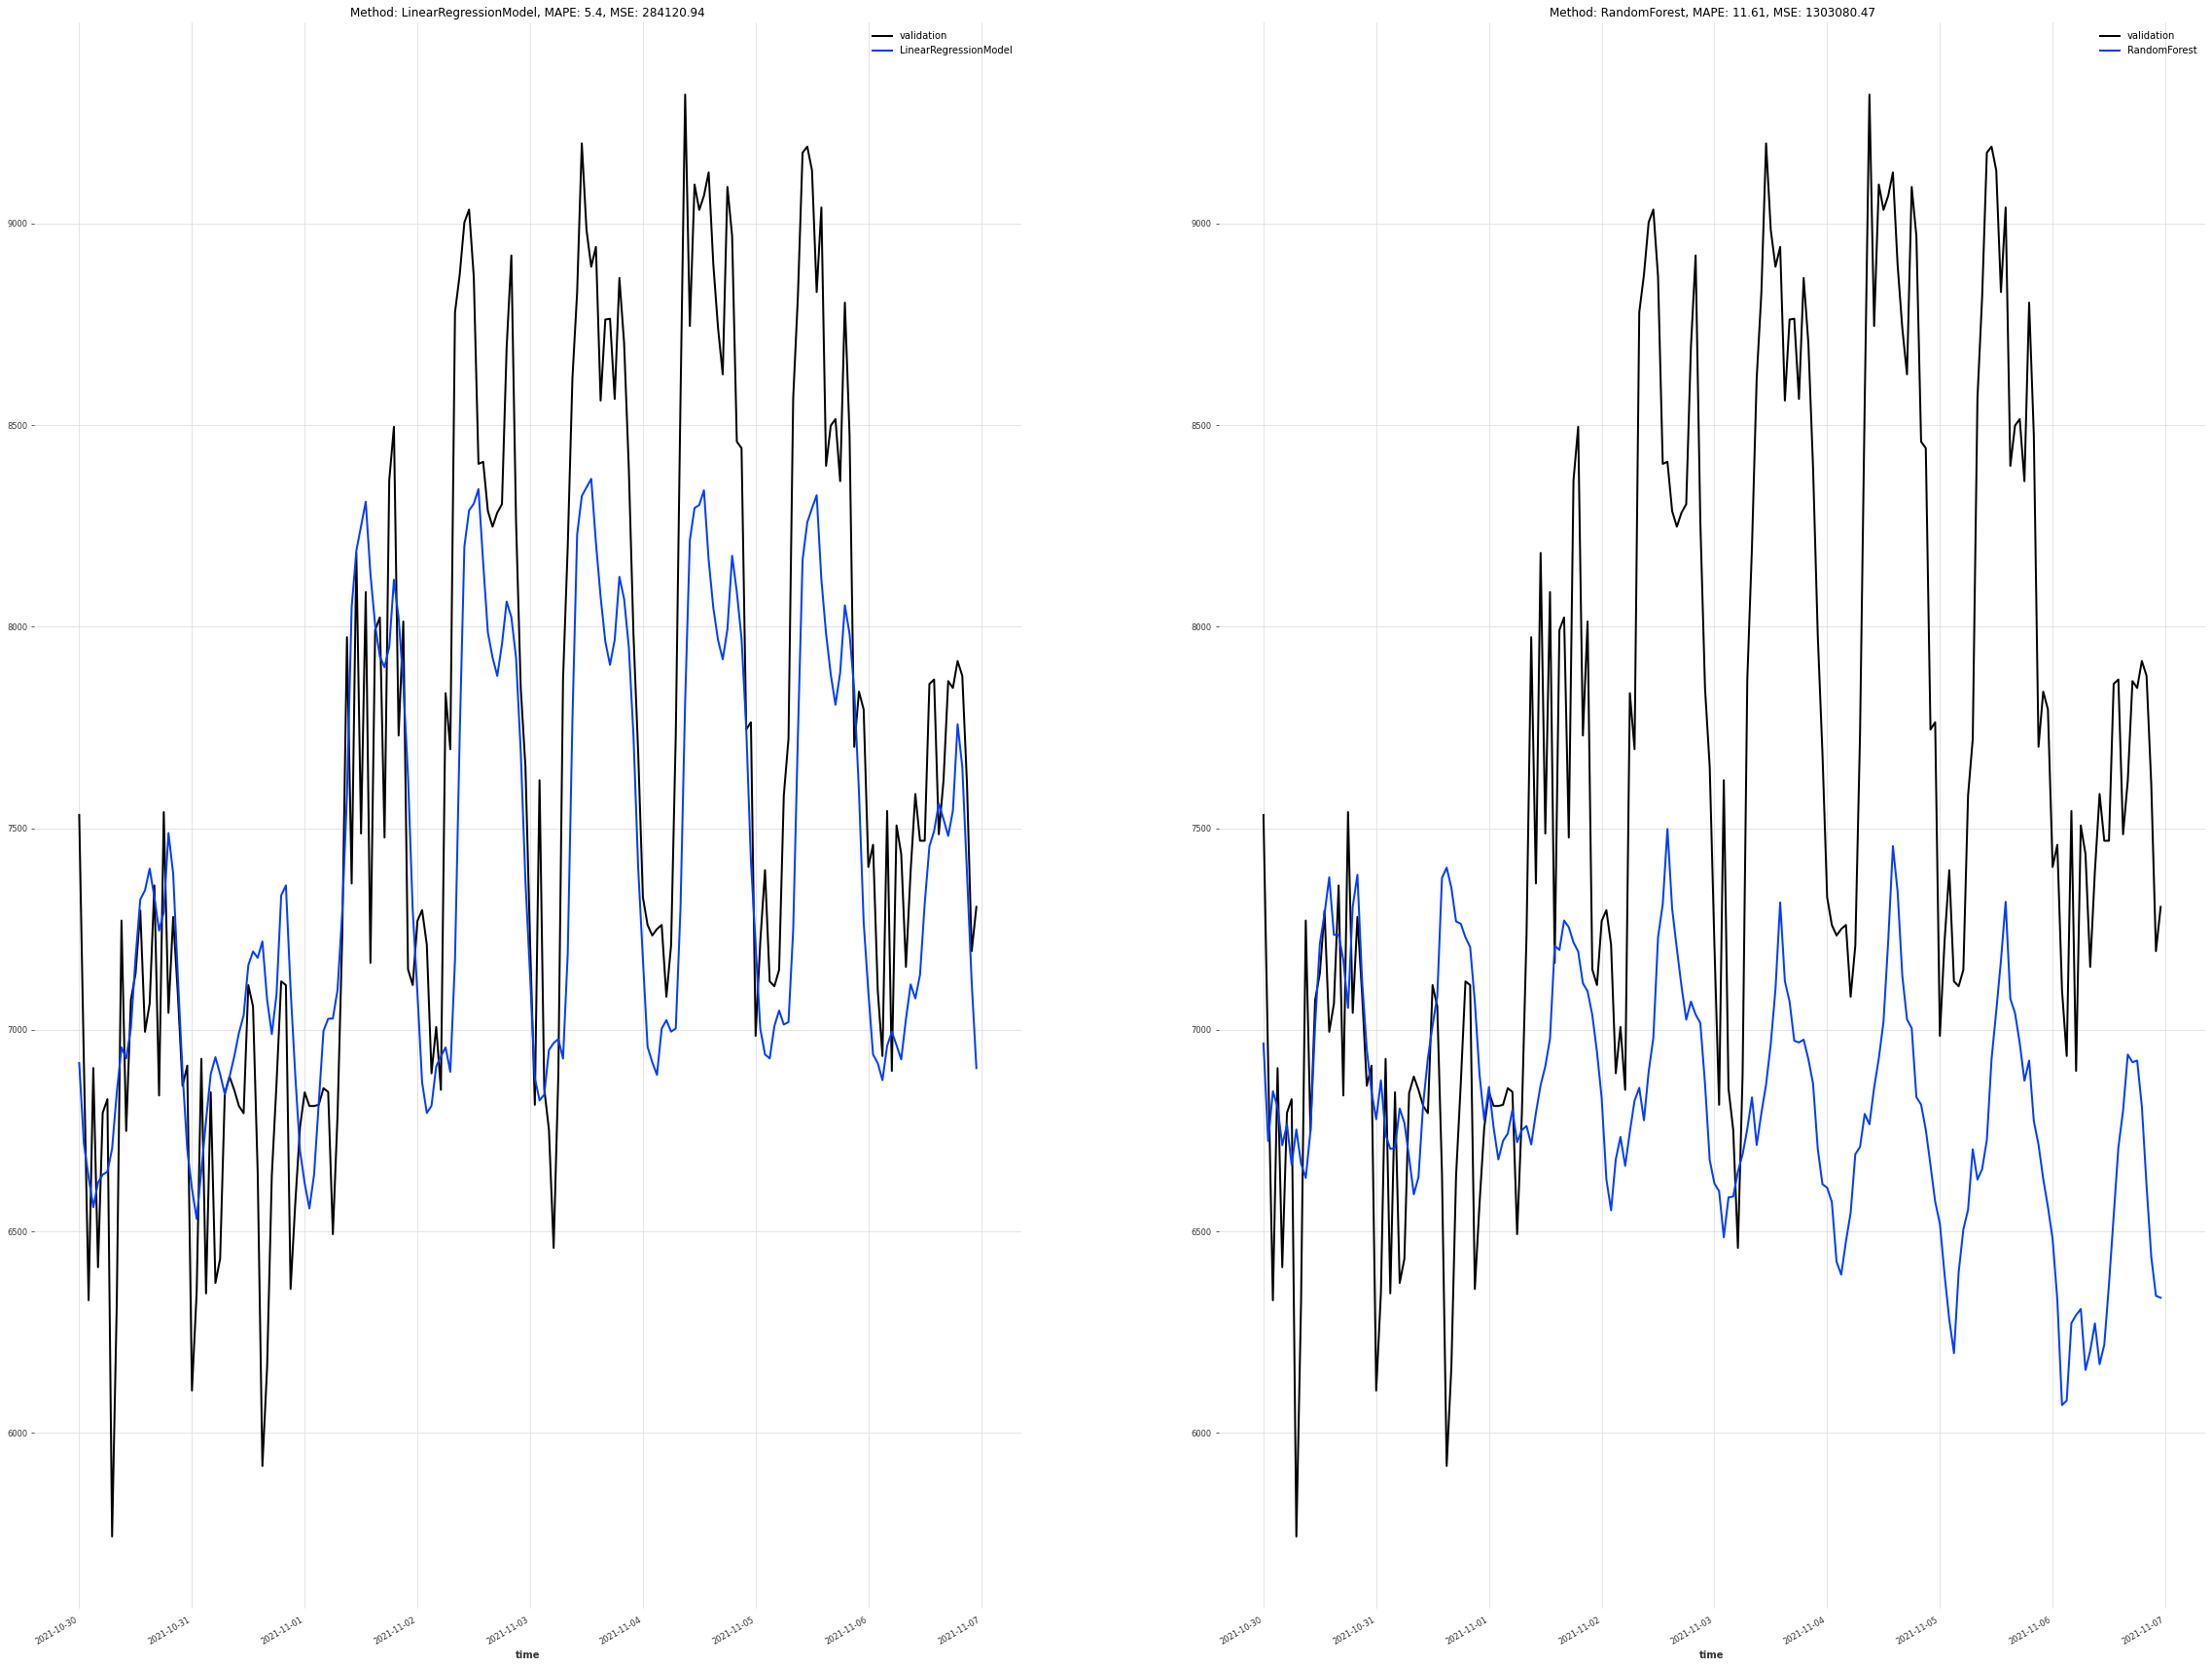

In [29]:
from darts.models import LinearRegressionModel, RandomForest
from darts.metrics import mape, mse

linear = LinearRegressionModel(lags=24, lags_past_covariates=24)
randomforest = RandomForest(lags=24, n_estimators=20, lags_past_covariates=24)

models = {
    "LinearRegressionModel" : linear,
    "RandomForest" : randomforest, # => not applicable, because of computer power we had to reduce trees to 20, which takes 4min for MAPE of 9.91
    # "VARIMA" : varima, only supports future_covariates
}

fig = plt.figure(figsize=(40, 30))
for i, (name, model) in enumerate(models.items()):
    print(f"Currently calculating {name}")
    model.fit(series=training, past_covariates=covariates)
    predictions = model.predict(n=len(validation), past_covariates=covariates)
    mape_score = round(mape(validation, predictions), 2)
    mse_score = round(mse(validation, predictions), 2)

    # plotting figure
    fig.add_subplot(1, 2, i+1)
    #training.plot(label="training")
    validation.plot(label="validation")
    predictions.plot(label=name)
    plt.title(f"Method: {name}, MAPE: {mape_score}, MSE: {mse_score}")
    plt.legend()
# fig.tight_layout()
plt.show()

## Comparison Linear Regression Model vs Linear Regression Model with Temporal Features

Currently calculating Linear Regression Model
Currently calculating Linear Regression Model with Temporal Features


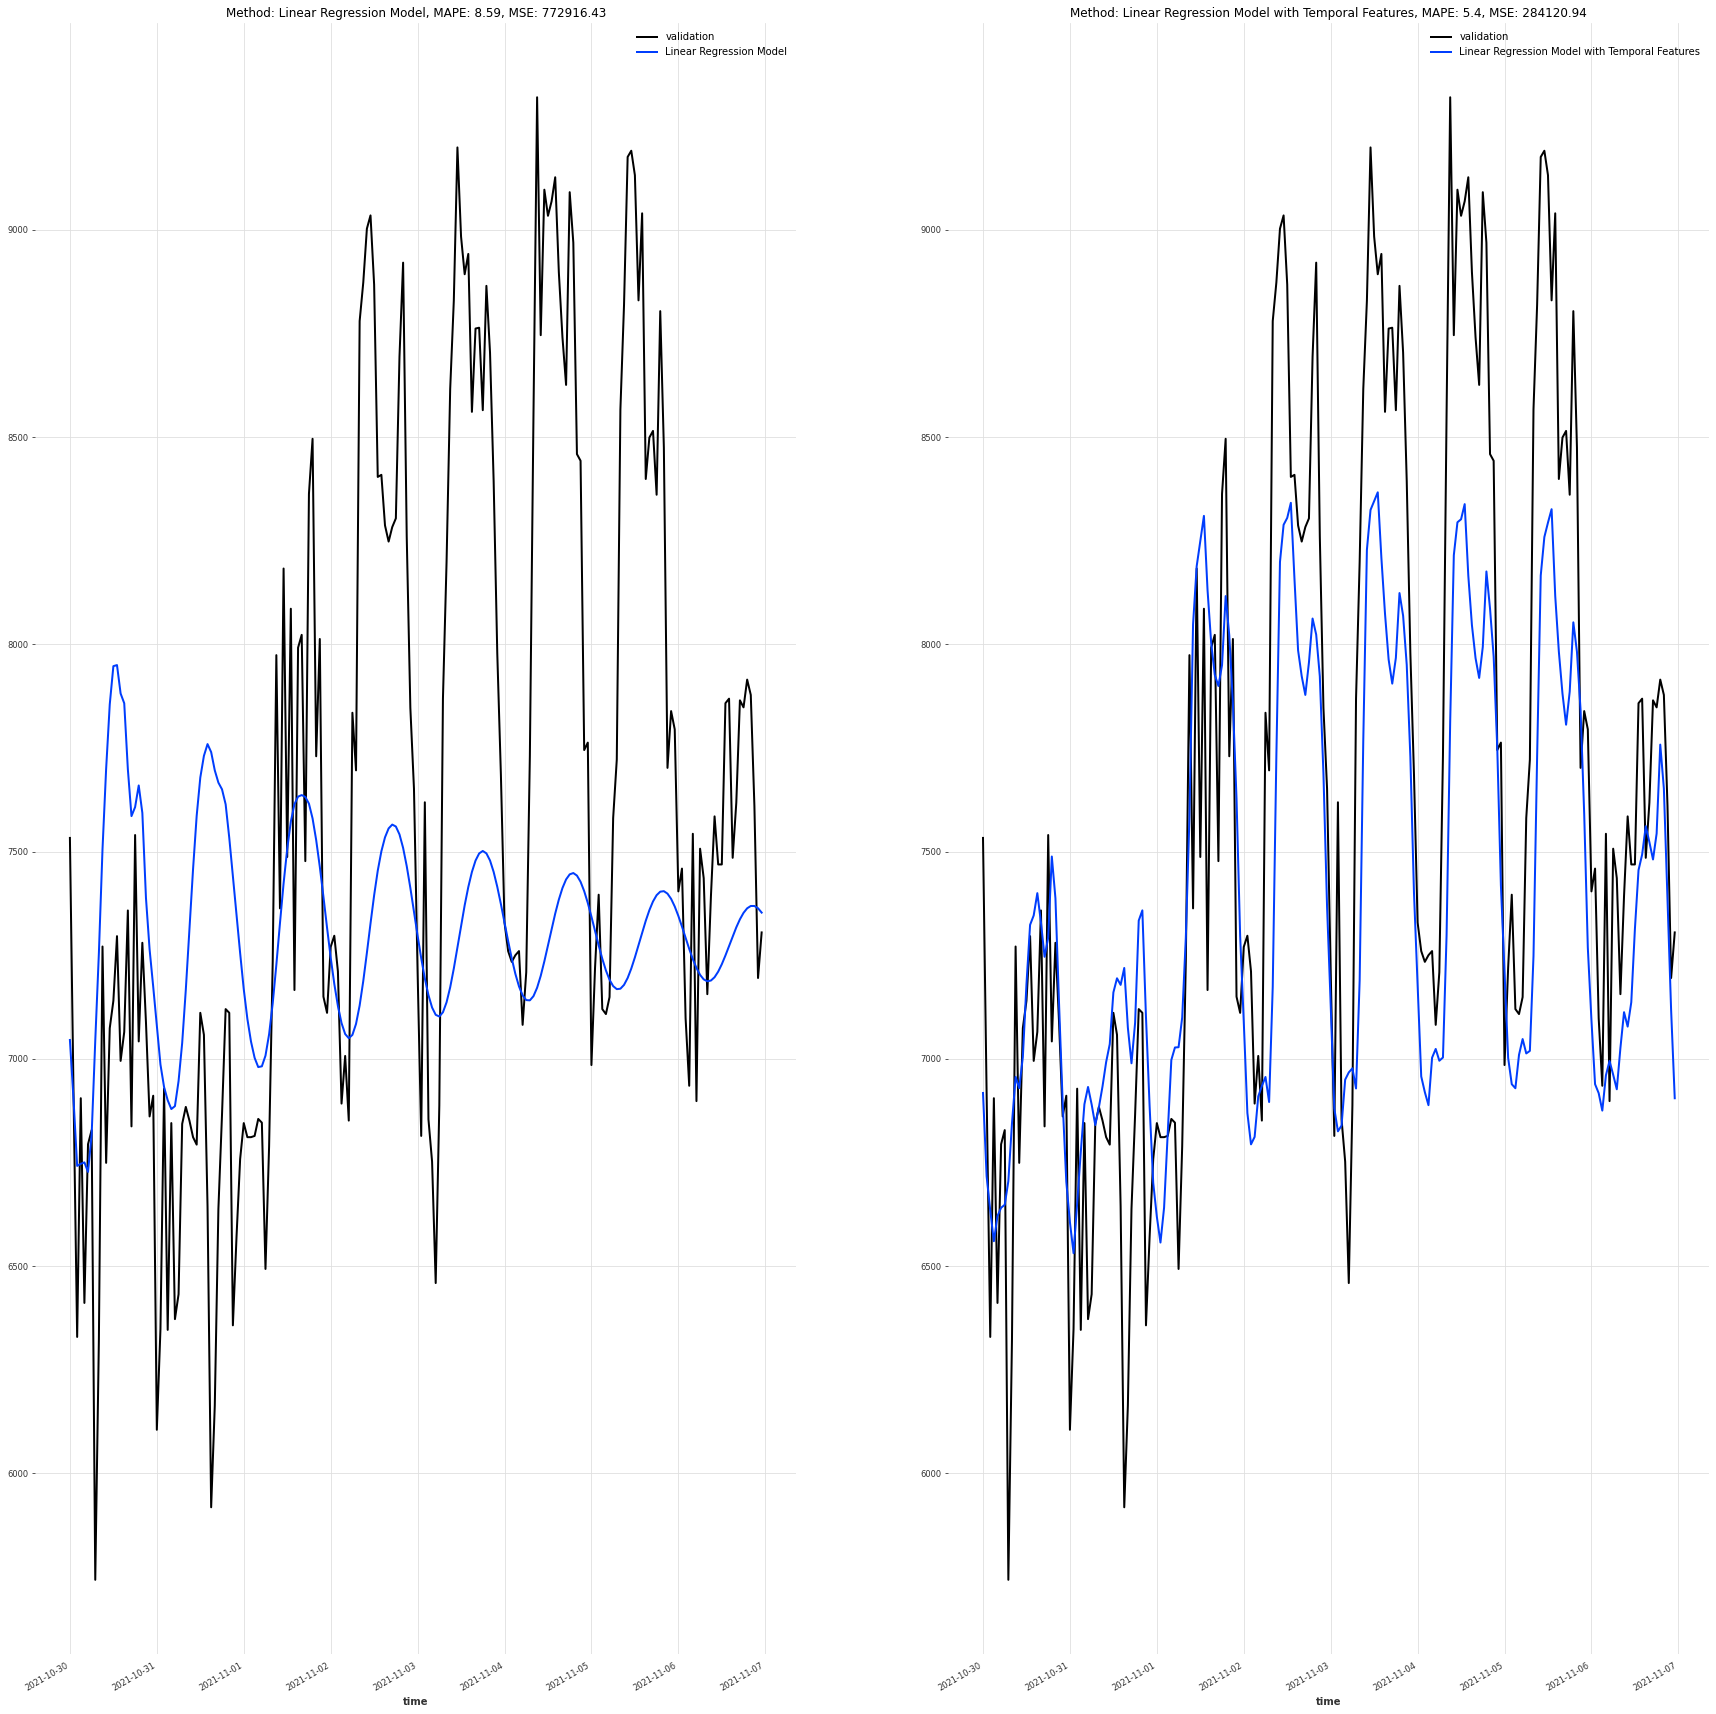

In [34]:
from darts.models import LinearRegressionModel
from darts.metrics import mape, mse

linear = LinearRegressionModel(lags=24)
linear_with_covariates = LinearRegressionModel(lags=24, lags_past_covariates=24)

models = {
    "Linear Regression Model" : linear,
    "Linear Regression Model with Temporal Features" : linear_with_covariates
}

fig = plt.figure(figsize=(30, 30))
for i, (name, model) in enumerate(models.items()):
    print(f"Currently calculating {name}")
    if (i == 0):
        model.fit(series=training)
        predictions = model.predict(n=len(validation))
    else:
        model.fit(series=training, past_covariates=covariates)
        predictions = model.predict(n=len(validation), past_covariates=covariates) 

    mape_score = round(mape(validation, predictions), 2)
    mse_score = round(mse(validation, predictions), 2)

    # plotting figure
    fig.add_subplot(1, 2, i+1)
    #training.plot(label="training")
    validation.plot(label="validation")
    predictions.plot(label=name)
    plt.title(f"Method: {name}, MAPE: {mape_score}, MSE: {mse_score}")
    plt.legend()
# fig.tight_layout()
plt.show()